# Cluster Analysis of Molecular Dynamics Trajectory Data

*A tutorial/workshop created by [Charlie Laughton](mailto:charles.laughton@nottingham.ac.uk)  for [CCP-BioSim](http://www.ccpbiosim.ac.uk)*

### Introduction
By the "jumping amongst minima" model of MD dynamics, we expect large ensembles/long trajectories to show clustering in conformational space. Cluster centres correspond to local minima conformations, and the sizes and shapes of the clusters tell us about the shape of the free energy surface.

The theory and practice of clustering is a massive subject that we can't cover much here; for a bit of an introduction, see [this Towards Data Science article](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68) and for a molecular-dynamics focussed discussion, [this article](https://pubs.acs.org/doi/10.1021/ct700119m) from the Cheatham group.

Here we illustrate how some of the clustering methods in the [scipy](https://scipy.org) Python package can be applied to MD trajectories/ensembles, and also look at another method developed by Rodriguez and Laio 
[(*Science*, 2014,  **344**, 1492-1495)](http://science.sciencemag.org/content/344/6191/1492) that seems - often - to work pretty well for MD type data.

A feature of all the clustering methods used here is that they are "agglomerative". This means there is no up-front decision by the user as to how many clusters there should be, which makes sense for MD-type applications where you hope the data will tell you where the clusters are. However in general there is still a point in the process where a human eye has to make a decision as to whether something is a cluster or not - you will see that here.

The data set we will investigate consists of 10,000 snapshots from a 100 nanosecond implicit solvent simulation of the "alanine dipeptide". We use PCA to help us visualise the distribution of the data in conformational space, and so how the clustering methods perform.

#### Requirements

If you are running this tutorial on the CCP-BioSim training cloud all required Python packages will be present. If you have cloned the repo to run the Jupyter notebook locally, you will need ('pip install'):

1. mdtraj
2. mdplus
3. numpy
4. scipy
5. rlcluster
6. matplotlib

-------
### Step 1: import the required libraries:

1. MDTraj to load and manipulate the trajectory data.
2. Matplotlib for the graphs
3. MDPlus for PCA
4. Scipy for clustering methods
5. RLCluster for Rodrigues-Laio clustering

In [43]:
import mdtraj as mdt
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from mdplus.pca import PCA
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.cluster.hierarchy import ward, fcluster, single, complete
import rlcluster
import time

### Step 2: Load the trajectory data and strip down to heavy atoms only

In [16]:
t = mdt.load('ala2.md.nc', top='ala2.prmtop')
heavy = t.topology.select('mass > 2.0')
t = t.atom_slice(heavy)
print(t)

<mdtraj.Trajectory with 10000 frames, 10 atoms, 3 residues, without unitcells>


### Step 3: Find a way of visualizing the data that will help you evaluate the performance of your clustering methods. 
Here we will use Principal Component Analysis of the snapshots to create a low-dimensional representation of their distribution:

Text(0, 0.5, 'explained variance (nm**2)')

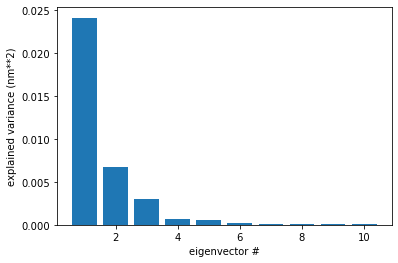

In [17]:
p = PCA()
scores = p.fit_transform(t.xyz)
plt.bar(range(1,11), p.eigenvalues[:10])
plt.xlabel('eigenvector #')
plt.ylabel('explained variance (nm**2)')

The `scores` matrix generated by the PCA process contains one row per snapshot. Each row contains the coordinates of the structure in the 30-dimensional PCA space. From the eigenvalue analysis above, we see that only the first 3 or so values in each row are "interesting" in that they show significant variance across the data set.

Create a utility function to plot data in the low-dimensional PCA space (it will save a lot of repeated code later). Create three views: one in the PC1/PC2 plane, one in the PC1/PC3 plane, and one in the PC2/PC3 plane.

In [18]:
def plot_distribution(axs, score_sets, title=None):
    """
    Plot selected scores data (more than one subset may be given)
    """
    if not isinstance(score_sets, list):
        score_sets = [score_sets]
    for scores in score_sets:
        axs[0].plot(scores[:, 0], scores[:, 1], '.')
        axs[1].plot(scores[:, 0], scores[:, 2], '.')
        axs[2].plot(scores[:, 1], scores[:, 2], '.')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')
    axs[1].set_title(title)

Now use it:

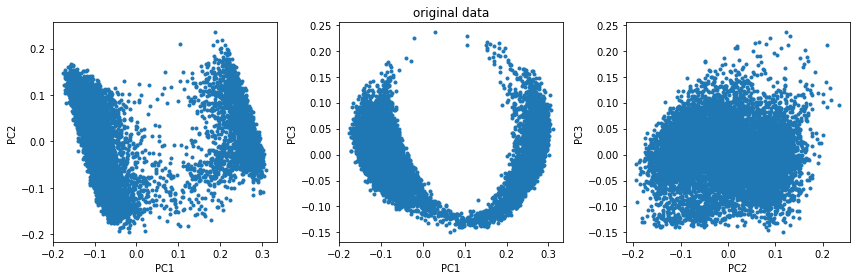

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
result = plot_distribution(axs, scores, 'original data')
plt.tight_layout()

### Step 4: Compare alternative clustering methods.

Here you look at the [single](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.single.html#scipy.cluster.hierarchy.single), [complete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.complete.html#scipy.cluster.hierarchy.complete) and [ward](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html#scipy.cluster.hierarchy.ward) methods in scipy, and the [Rodriguez-Laio](http://science.sciencemag.org/content/344/6191/1492) approach.

#### Step 4.0: Create the distance matrix
All clustering methods used here require the pre-calculation of the distances between all samples, i.e. the creation of a 2D distance matrix D where D[i, j] is the distance between samples i and j. Because D[i, j] = D[j, i] and D[i, i] = 0, its possible to save memory and calculation effort by just creating a "condensed" distance matrix: the upper triangle of the full 2D matrix. The `scipy` clustering methods can use a condensed distance matrix directly, the `rlcluster` method needs the full 2D version, but that's easy as `scipy` includes a utility function `squareform` that can convert between the two formats.

For structure data like molecular conformations, RMSD makes a good distance metric - but others are possible. `MDTraj` includes a very fast routine that can calculate the RMSD between one conformation in a trajectory and a set of others, but to create the full (or condensed) 2D matrix we have to create our own routine:

In [20]:
rmsdlist = []
for i in range(t.n_frames - 1):
    rmsdlist.append(mdt.rmsd(t[i+1:], t[i]))
rmsds = np.concatenate(rmsdlist)

The resulting array `rmsds` is a "condensed" distance matrix.

#### Step 4.1: Look at RL first:

The RL cluster method works on the full 2D distance matrix and really has only one adjustable parameter, `sigma`, which is related to the threshold 'distance' above which cluster merging stops. The default value of `sigma` is 5.0, this is often a good guess but typically (and this will go for other agglomerative clustering methods as well, as you will see later) there is an iterative process of trying a value, assessing the performance, and then adusting it if required.

In [21]:
rl_result = rlcluster.cluster(squareform(rmsds), sigma=2.0) # a value of 2.0 works here

The RL method uses a "decision graph" to help assess whether the choice of sigma is appropriate (see the paper). The Python package includes a metod to generate this:

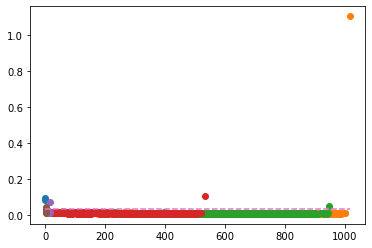

In [22]:
rlcluster.decision_graph(rl_result, plt.axes())

It seems that sigma=2.0 was a good choice. There seems a very clear separation (the dotted line, related to the chosen sigma value) between a few cluster centres and the rest of the data. The label assigned to each sample (the index of the cluster that it has been assigned to) is in the `.assignments` attribute of `rl_result`. We will use this to separate the clusters in the scores matrix. A value of 0 is used to mark outliers, so we skip over that:

In [23]:
rl_labels = rl_result.assignments
rl_clusters = [scores[rl_labels == i] for i in set(rl_labels) if i != 0]

#### Step 4.2:  `Single` clustering:

The `scipy` methods all work the same way. They take a distance matrix (in condensed form) and return a "linkage matrix" - see the scipy documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) for an explanation of the format of this matrix.

Text(0, 0.5, 'distance threshold')

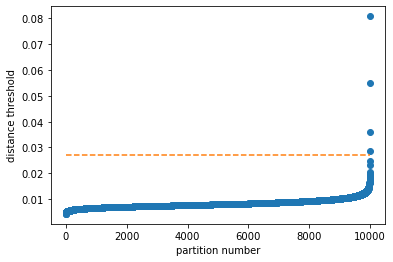

In [24]:
Zsingle = single(rmsds)
plt.plot(Zsingle[:, 2], 'o')
plt.plot([0.0, 10000], [0.027, 0.027], '--')
plt.xlabel('partition number')
plt.ylabel('distance threshold')

The `scipy` methods don't include a "decision graph" type tool, but a plot of selected data out of the linkage matrix Z does a similar job (see above). A cut at 0.027 looks reasonable, so we can then use this with the `fcluster` routine to produce a vector of labels for each sample:

In [25]:
single_labels = fcluster(Zsingle, 0.027, criterion='distance')
single_clusters = [scores[single_labels == i] for i in set(single_labels) if i != 0]

#### Step 4.3:  `complete` clustering:

The process is the same: create the linkage matrix, graph data from it, decide on the optimal clustering threshold from examination of the graph, and use `fcluster` to generate the labels:

Text(0, 0.5, 'distance threshold')

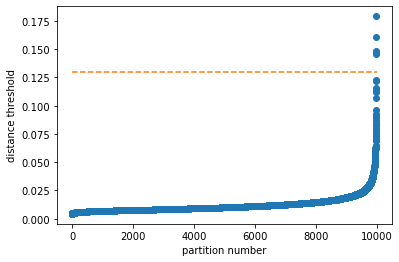

In [26]:
Zcomplete = complete(rmsds)
plt.plot(Zcomplete[:, 2], 'o')
plt.plot([0.0, 10000], [0.13, 0.13], '--') # we see - below - that this seems reasonable
plt.xlabel('partition number')
plt.ylabel('distance threshold')

In [27]:
complete_labels = fcluster(Zcomplete, 0.13, criterion='distance')
complete_clusters = [scores[complete_labels == i] for i in set(complete_labels) if i != 0]

#### Step 4.4:  `ward` clustering:

Text(0, 0.5, 'distance threshold')

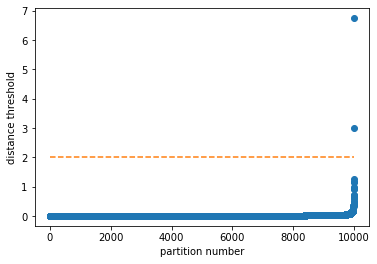

In [28]:
Zward = ward(rmsds)
plt.plot(Zward[:, 2], 'o')
plt.plot([0.0, 10000], [2.0, 2.0], '--') # this turns out to look reasonable
plt.xlabel('partition number')
plt.ylabel('distance threshold')

In [29]:
ward_labels = fcluster(Zward, 2.0, criterion='distance')
ward_clusters = [scores[ward_labels == i] for i in set(ward_labels) if i != 0]

#### Step 5: Compare the results

Sort each list of clusters so the biggest one comes first (so the colour coding of the plots is consistent), then plot them:

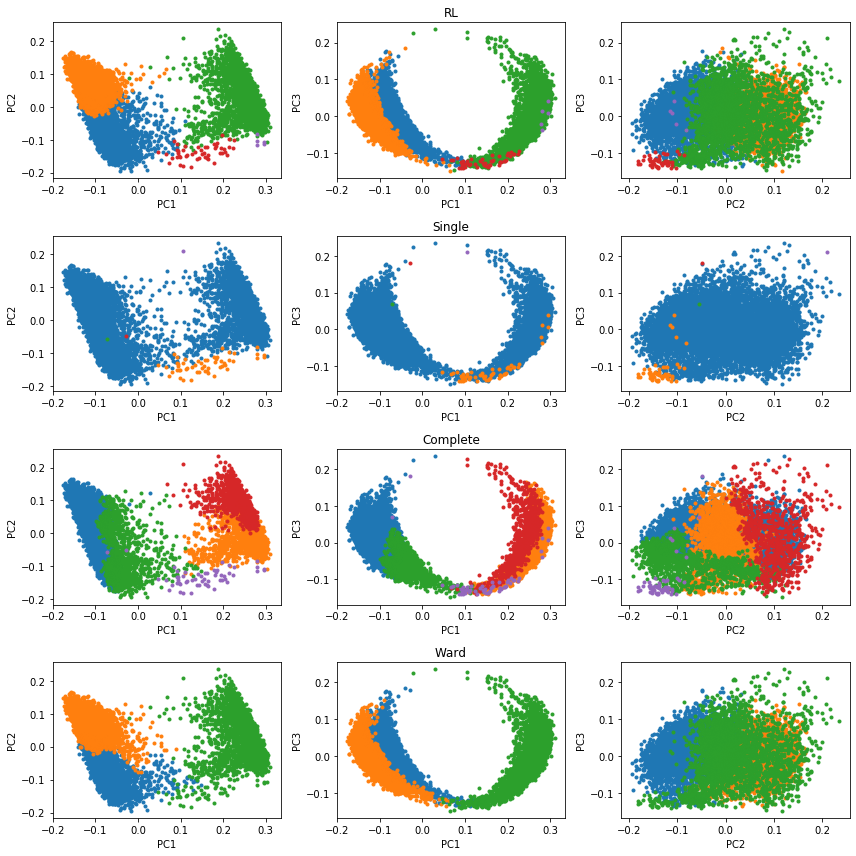

In [30]:
ward_clusters.sort(key=lambda l: -len(l))
rl_clusters.sort(key=lambda l: -len(l))
single_clusters.sort(key=lambda l: -len(l))
complete_clusters.sort(key=lambda l: -len(l))

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
plot_distribution(axs[0], rl_clusters, 'RL')
plot_distribution(axs[1], single_clusters, 'Single')
plot_distribution(axs[2], complete_clusters, 'Complete')
plot_distribution(axs[3], ward_clusters, 'Ward')
plt.tight_layout()

Single is obviously bad, complete looks unlikely. Ward and RL look reasonable and quite similar, but are they "right"?

--------
### Step 6: Evaluation of the different methods
We have been doing all the work so far in Cartesian space, but the conformation of the alanine dipeptide is much more simply described by the values of the peptide bond phi and psi angles - there are no other significant degrees of freedom. Let's look at the data in the form of the familiar Ramachandran map:

/Users/pazcal/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0, 0.5, 'psi (radians)')

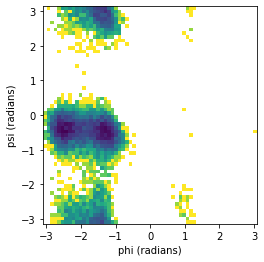

In [31]:
phipsi_atoms = [[1, 3, 4, 6], [3, 4, 6, 7]] # indices of the atoms defining phi and psi
phipsi = mdt.compute_dihedrals(t, phipsi_atoms)

Z, x_edges, y_edges = np.histogram2d(phipsi[:, 0], phipsi[:, 1], bins=60)
plt.imshow(-np.log(Z.T), extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower')
plt.xlabel('phi (radians)')
plt.ylabel('psi (radians)')

We can identify cluster centres by eye in this map:

/Users/pazcal/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'psi')

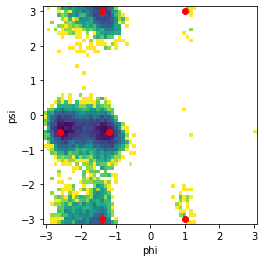

In [32]:
centres = np.array([[-1.2, -0.5], [-2.6, -0.5], [-1.4, 3], [1, 3], [-1.4, -3], [1, -3]])
plt.imshow(-np.log(Z.T), extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower')
plt.plot(centres[:, 0], centres[:, 1], 'ro')
plt.xlabel('phi')
plt.ylabel('psi')

#### Step 6.1: Use the Ramachandran map to generate a reference clustering.
Assign each snapshot to the centre its phi and psi values are closest to. We use scipy's fast `cdist` function for this. The last two centres in our list are really the same as the two previous ones - just split by the -twopi/+twopi boundary in psi, so we reassign all points with label=5 to have label=3 and label=6 to habe label=4. Then we generate our list of clusters and sort by size, as before:

In [33]:
adist = cdist(phipsi, centres)

phipsi_labels = adist.argmin(axis=1) + 1
phipsi_labels = np.where(phipsi_labels==5, 3, phipsi_labels)
phipsi_labels = np.where(phipsi_labels==6, 4, phipsi_labels)

phipsi_clusters = [scores[phipsi_labels == i] for i in set(phipsi_labels) if i != 0]
phipsi_clusters.sort(key=lambda l: -len(l))

#### Step 6.2: Compare the reference with Ward and RL results.
Now we can compare the clustering done in torsional space according to the Ramachandran map with the Ward and RL clusterings done in Cartesian space (for this system, a much tougher challenge):

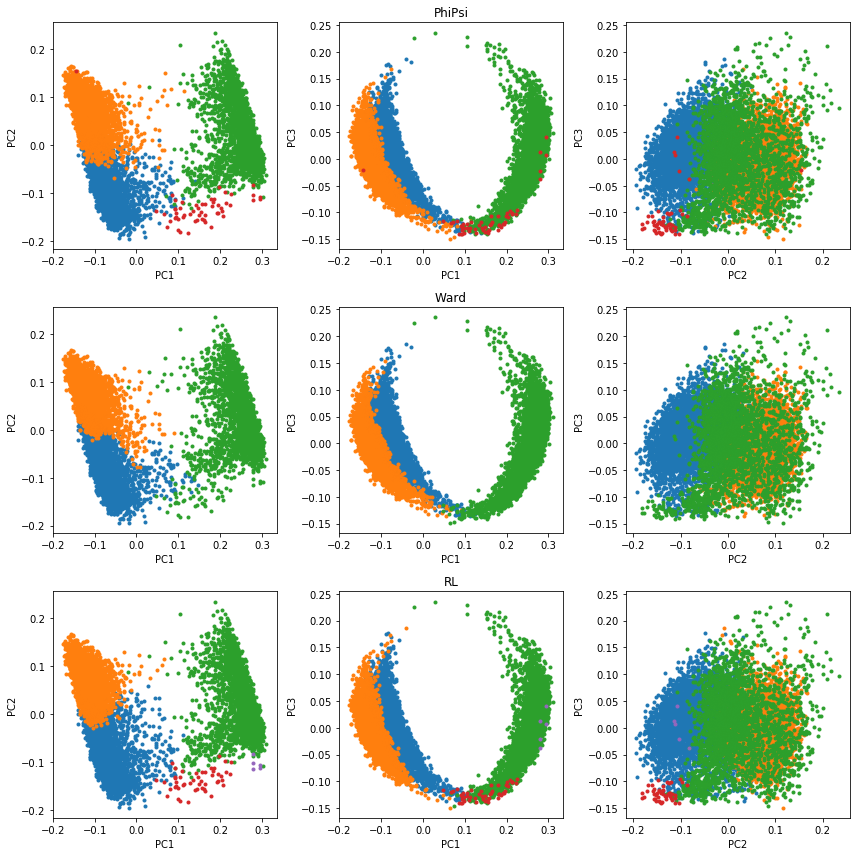

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plot_distribution(axs[0], phipsi_clusters, 'PhiPsi')
plot_distribution(axs[1], ward_clusters, 'Ward')
plot_distribution(axs[2], rl_clusters, 'RL')
plt.tight_layout()

We see that both Ward and RL have done a good job, but the RL method seems to edge it.

--------------

### Sampling and clustering

It will be very evident that the performance of a clustering method is going to be sensitive to the amount of data available. Let's have a bit of a look at that.

We will take smaller and smaller subsets of the full trajectory, and see how that affects clustering using the RL approach

In [37]:
divisors = [1, 2, 4, 8, 16]

#subrmsds = [squareform(rmsds)[::d][:,::d] for d in divisors]
rmsdsq = squareform(rmsds)
subrmsds = [rmsdsq[::d, ::d] for d in divisors]

all_rl_clusters = []
for i, d in enumerate(divisors):
    result = rlcluster.cluster(subrmsds[i], sigma=2.0)
    labels = result.assignments
    clusters = [scores[::d][labels == i] for i in set(labels) if i != 0]
    clusters.sort(key=lambda l: -len(l))
    all_rl_clusters.append(clusters)
    

Now plot the data:

sample size:  10000  number of clusters: 5
sample size:   5000  number of clusters: 5
sample size:   2500  number of clusters: 3
sample size:   1250  number of clusters: 3
sample size:    625  number of clusters: 2


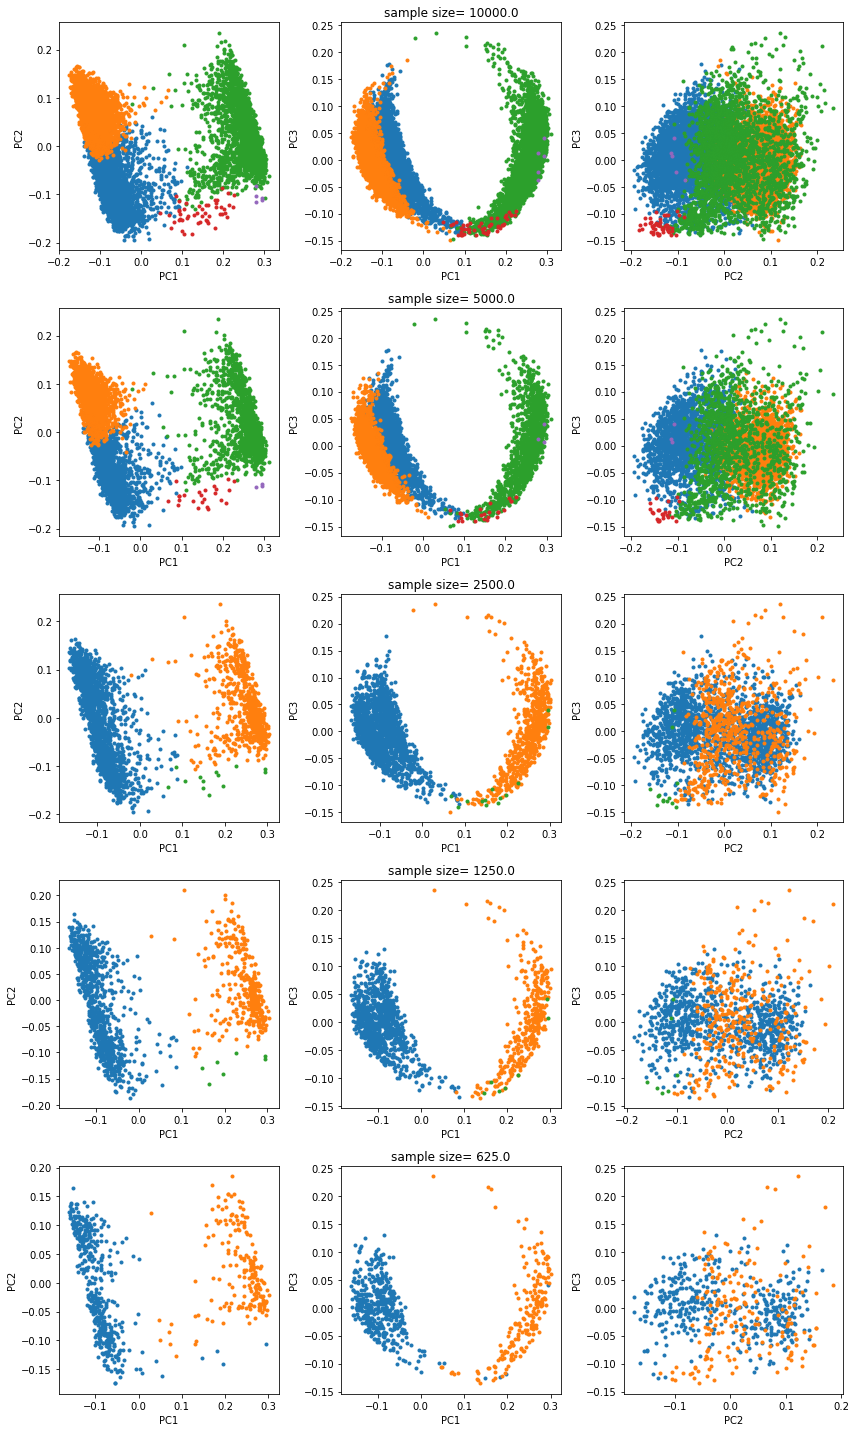

In [38]:
nd = len(divisors)
fig, axs = plt.subplots(nd, 3, figsize=(12, 4*nd))
for i, clusters in enumerate(all_rl_clusters):
    plot_distribution(axs[i], clusters, 'sample size= {}'.format(10000/divisors[i]))
    print('sample size: {:6.0f}  number of clusters: {}'.format(10000/divisors[i], len(clusters)))
plt.tight_layout()

## Summary:

Clustering is tricky, and subjective. Some key points:

1. Compare different methods.
2. There is always a bit of subjectivity - be transparent and always show how you decided on, for example, what clustering distance threshold to use.
3. Project your data into the "right" space and use an appropriate distance metric, and your life will be easier. Here we saw that distributions and clustering that were quite tricky when attempted in Cartesian space with RMSD as the distance metric became almost trivial if torsion angle space was used instead. Unfortunately in a more complex system this can be much harder to do; the good news is that even with a generic RMSD-based approach, methods like Ward and Rodriguez-Laio can work well.
4. No clustering method will work well if there isn't enough data. Conversely, when adding more data doesn't change the clustering, that may be useful evidence of convergence.

## Follow up work

This notebook has been presented more as a demonstration/tutorial than as an interactive workshop, but there are plenty of ways you may wish to extend it:

1. Explore what happens if you make different decisions about the cutoffs used to control the cluster merging process.
2. Explore alternative clustering algorithms - most of the scipy methods have a very similar calling signature and you can 'swap out' methods here for alternative ones quite easily.
3. Explore your own data - the Ramachandran analysis based section is very specific to the alanine dipeptide test case used here, but for the other sections of the notebook it should be straightforward to substitute in your own trajectory data and analyse that.

## Footnote: fast 2D RMSD calculations

The RMSD calculation routines in MDTraj are very fast, but as you will have noticed when you ran this step, it's still a time-consuming process, and it scales as the square of the number of samples so can eventually become prohibitive.

If you can accept a small degree of approximation in the RMSD calculation (and most clustering applications will be fine with this), there is a PCA method that can be several times faster. Its based on the fact that in the full 3N-6 dimensional PCA space, the Cartesian distance between points is very close to their RMSD, multiplied by the square root of the number of atoms. Numpy contains a function `pdist` that can calculate Cartesian distance matrices very fast, so you can get an approximate 2D RMSD matrix this way.

In the code below we test the PCA approach agains the MDTRaj approach, checking accuracy and speed, for larger and larger data sets:

In [48]:
def rmsd2d_mdt(t):
    """
    Returns the condensed 2D RMSD matrix for the structures in trajectory t
    """
    rmsdlist = []
    for i in range(t.n_frames - 1):
        rmsdlist.append(mdt.rmsd(t[i+1:], t[i]))
    rmsds = np.concatenate(rmsdlist)
    return rmsds

def rmsd2d_pca(t):
    """
    Returns an approximated condensed 2D distance matrix for the structures in trajectory t
    """
    p = PCA()
    scores = p.fit_transform(t.xyz)
    scores /= np.sqrt(t.n_atoms)
    return pdist(scores)

def mue(d1, d2):
    """
    The mean unsigned error between two sets of distance/rmsd calculations
    """
    return np.abs(d1 -d2).mean()


for n_frames in range(1000, 11000, 1000):
    t_truncated = t[:n_frames]
    start = time.time()
    rmsd_mdt = rmsd2d_mdt(t_truncated)
    mdt_time = time.time() - start

    start = time.time()
    rmsd_pca = rmsd2d_pca(t_truncated)
    pca_time = time.time() - start

    print('n_frames:{:6d} mdt time: {:5.2f} pca time: {:5.2f} mue: {:7.5f}'.format(
           n_frames, mdt_time, pca_time, mue(rmsd_mdt, rmsd_pca)))
    

n_frames:  1000 mdt time:  0.39 pca time:  0.06 mue: 0.00038
n_frames:  2000 mdt time:  1.02 pca time:  0.09 mue: 0.00047
n_frames:  3000 mdt time:  1.98 pca time:  0.21 mue: 0.00050
n_frames:  4000 mdt time:  3.06 pca time:  0.30 mue: 0.00059
n_frames:  5000 mdt time:  4.50 pca time:  0.44 mue: 0.00059
n_frames:  6000 mdt time:  6.67 pca time:  0.63 mue: 0.00059
n_frames:  7000 mdt time:  8.68 pca time:  0.84 mue: 0.00060
n_frames:  8000 mdt time: 10.85 pca time:  1.07 mue: 0.00060
n_frames:  9000 mdt time: 13.32 pca time:  1.30 mue: 0.00060
n_frames: 10000 mdt time: 16.63 pca time:  1.79 mue: 0.00059


The performance you observe will be very data set and machine-dependent, but you might see the PCA method being up to ten times faster, for all trajectory sizes.